In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import corner

//anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


### Import my functions from the MRT_Funcs file

In [2]:
from ipynb.fs.full.MRT_Funcs import SMAMeanReversion_strat, stratBacktest, applyPortfolioStrat, getStratStats, portfolio_DrawdownStats, portfolioBacktest, sum_metrics, plot_portfolio_backtest, portfolio_dashboard, hyperparam_gridsearch, clean_stat_grid, save_gridsearch, load_gridsearch, plot_gridsearch_results

### Run a single-stock backtest

2020-11-07 00:00:00


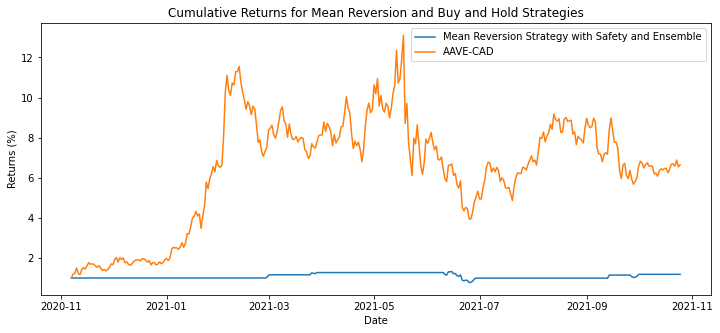

Safe+Ensemble Strategy Statistics 

                       strat_stats  base_stats
tot_returns                  0.184       6.710
annual_returns               0.128       3.298
annual_volatility            0.390       1.221
max_drawdown                 0.542       9.157
max_drawdown_duration      132.000     160.000


In [3]:
#Set strategy params
ticker = 'AAVE-CAD'
start_date = '2010-05-01'
end_date = '2021-10-25'
strat='SMA_MR'
verbose = False
safety = True
SMA = 15
threshold = 0.10
safety_threshold = 0.15
short_term_sma=10
long_term_sma=30
short_long_threshold=0.05
#Pack the strategy settings
strat_settings1 = [ticker, strat, SMA, threshold, safety, safety_threshold, short_term_sma, long_term_sma, short_long_threshold, start_date,end_date]

#Run the backtest
data = stratBacktest(strat_settings1)

#Calculate backtest stats
stats_dict = getStratStats(data)
df_stats = pd.DataFrame(stats_dict).round(3)

#Normalize backtest results
first_valid_day = data.first_valid_index()
print(first_valid_day)
data_normalized = data/data.loc[first_valid_day]

#Plot the results
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data_normalized['strat_cum_returns'], label='Mean Reversion Strategy with Safety and Ensemble')
ax.plot(data_normalized['cum_returns'], label=f'{ticker}')
ax.set_xlabel('Date')
ax.set_ylabel('Returns (%)')
ax.set_title('Cumulative Returns for Mean Reversion and Buy and Hold Strategies')

ax.legend()
plt.show()

print('Safe+Ensemble Strategy Statistics \n')
print(df_stats)

### Get portfolio decisions for today

In [4]:
#List of stocks we want to consider in our portfolio
#tickers = ['ETH-CAD','BTC-CAD','ADA-CAD','BNB-CAD','SNP','GOOGL','AAPL']
tickers = ['BTC-CAD','CRV-CAD','COMP-CAD','ETH-CAD','LINK-CAD']
#tickers = ['AAVE-CAD','BAL-CAD','BAT-CAD','BCH-CAD','BTC-CAD','COMP-CAD','CRV-CAD','DOGE-CAD','ETH-CAD','FIL-CAD','KNC-CAD','LINK-CAD','LTC-CAD','MANA-CAD','MATIC-CAD','MKR-CAD','SNX-CAD','SUSHI-CAD','UMA-CAD','UNI3-CAD','YFI-CAD','ZRX-CAD']
#tickers = ['TSLA','AAPL','TD','AMZN','SHOP','MSFT','RY','BNS','NVDA','CNR','BMO','FTS','ARKK','ABNB','NFLX','COIN','FB','BCE','VOO','DOL','SQ','KO','GOOGL','WMT']
current_positions = [1]*len(tickers)

#Set strategy params
strat_func = SMAMeanReversion_strat
SMA = 15 #have to make sure this is less than 2*long_term_sma, otherwise not enough data is downloaded and extension returns nan
threshold = 0.1
safety = False
safety_threshold = 0.15
short_term_sma=10
long_term_sma=30
short_long_threshold=0.05
tp_threshold = 0.7
#Pack the strategy settings
strat_settings2 = [strat_func, tickers, current_positions, SMA, threshold, safety, safety_threshold, short_term_sma, long_term_sma, short_long_threshold, tp_threshold]

#Apply strategy to portfolio
decisions = applyPortfolioStrat(strat_settings2)
portfolio_dashboard(decisions)

,ticker,latest_close_price,expected_price,extension,extension_position,short_long ratio,short_long_position,movement,take_profit_price,position
0,BTC-CAD,60037.504,64229.681,-0.028,0.000,0.915,1.000,Hold,62972.028,0.000
1,CRV-CAD,5.272,5.158,0.077,0.000,0.901,1.000,Hold,5.192,0.000
2,COMP-CAD,0.000,nan,nan,0.000,nan,0.000,Hold,nan,0.000
3,ETH-CAD,4978.010,5254.278,-0.039,0.000,0.946,1.000,Hold,5171.398,0.000
4,LINK-CAD,24.031,26.796,-0.037,0.000,0.847,1.000,Hold,25.966,0.000


### Run a portfolio backtest

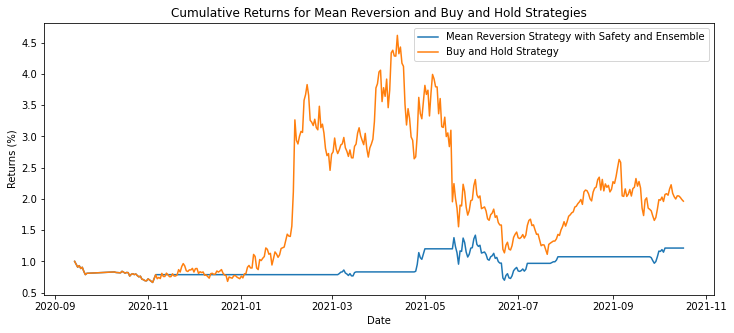

Portfolio Backtest Statistics


,strat_stats,base_stats
tot_returns,0.180,0.911
annual_returns,0.117,0.538
annual_volatility,0.593,1.192
max_drawdown,0.776,6.889
max_drawdown_duration,225.000,187.000


In [5]:
#List of stocks we want to consider in our portfolio
#tickers = ['AAVE-CAD','BAL-CAD','BAT-CAD','BCH-CAD','BTC-CAD','COMP-CAD','CRV-CAD','DOGE-CAD','ETH-CAD','FIL-CAD','KNC-CAD','LINK-CAD','LTC-CAD','MANA-CAD','MATIC-CAD','MKR-CAD','SNX-CAD','SUSHI-CAD','UMA-CAD','UNI3-CAD','YFI-CAD','ZRX-CAD']
#tickers = ['TSLA','AAPL','TD','AMZN','SHOP','MSFT','RY','BNS','NVDA','CNR','BMO','FTS','ARKK','NFLX','FB','BCE','VOO','DOL','SQ','KO','GOOGL','WMT']
#tickers = ['SNP','GOOGL','AAPL','TD','AMZN','BMO','CNR','NVDA','ARKK','NFLX','FB','VOO','GOOGL','WMT']
tickers = ['BAT-CAD','BTC-CAD','ETH-CAD','CRV-CAD','ZRX-CAD']
#tickers = ['SNP','TSLA']
verbose = False

start_date = '2015-05-01'
end_date = '2021-10-17'
strat='SMA_MR'
SMA = 30
threshold = 0.1
safety = True
safety_threshold = 0.15
short_term_sma=10
long_term_sma=30
short_long_threshold=0.05

strat_settings3 = [tickers, strat, SMA, threshold, safety, safety_threshold, short_term_sma, long_term_sma, short_long_threshold, start_date, end_date, verbose]
#Run the backtest on the entire portfolio
portfolio_returns, portfolio_stats = portfolioBacktest(strat_settings3)
#Plot portfolio backtest returns
plot_portfolio_backtest(portfolio_returns)
#Print portfolio backtest statistics
print('Portfolio Backtest Statistics')
round(portfolio_stats,3)

## Run a hyperparameter gridsearch on the portfolio

In [5]:
tickers = ['BAT-CAD','BTC-CAD','ETH-CAD','CRV-CAD','ZRX-CAD']
N = 1 #Number of pts to use in each grid dimension
stat_grid, param_vecs = hyperparam_gridsearch(tickers, N)
stat_gridf = clean_stat_grid(stat_grid) #Filter out unreasonably small, large, and negative values from the results
save_gridsearch(param_vecs, stat_gridf, N) #Save results

Performing hyperparameter gridsearch. Grid size= 4096
0  of  4096  gridpoints
64  of  4096  gridpoints
c
c
c
c
c
c
c
c
c
c
128  of  4096  gridpoints
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
192  of  4096  gridpoints
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
256  of  4096  gridpoints
320  of  4096  gridpoints
384  of  4096  gridpoints
448  of  4096  gridpoints
512  of  4096  gridpoints
576  of  4096  gridpoints
640  of  4096  gridpoints
704  of  4096  gridpoints
768  of  4096  gridpoints
832  of  4096  gridpoints
896  of  4096  gridpoints
960  of  4096  gridpoints
1024  of  4096  gridpoints
1088  of  4096  gridpoints
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
1152  of  4096  gridpoints
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
1216  of  4096  gridpoints
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
c
1280  of  4096  gridpoint

## Plot a histogram of the gridsearch results (annual return ratio)

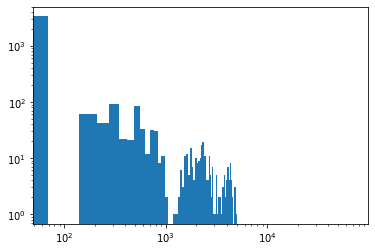

In [7]:
npts = N**6
stat_vec = np.reshape(stat_gridf, npts) #Reshape stats into a vector so we can histogram it

f = plt.hist(stat_vec, bins=1000, log='True')
plt.xscale('log')

In [4]:
save_gridsearch(param_vecs, stat_gridf, N) #Save results of gridsearch

Saving Gridsearch Results...
Results Saved


In [3]:
N=4
param_vecs, stat_grid = load_gridsearch(N) #Load results of gridsearch

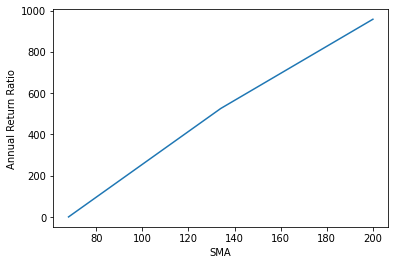

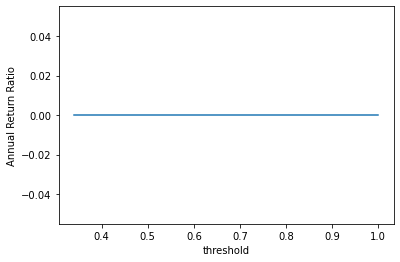

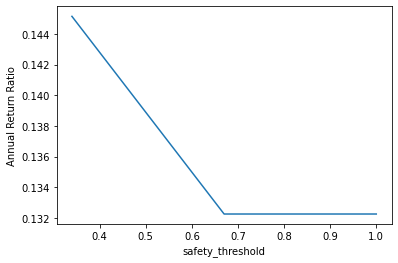

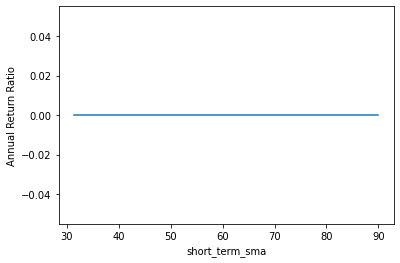

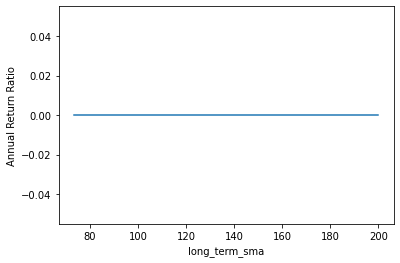

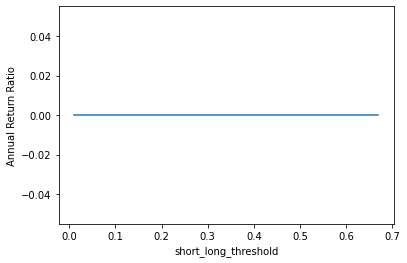

In [4]:
stat_vecs = plot_gridsearch_results(stat_grid, param_vecs, N) #Plot results of gridsearch averaged over each hyperparam